In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy



In [2]:
# Define the feature extractor (f)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Define the classification head (θ)
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Synthesizer: A simple generator for model inversion
class Synthesizer(nn.Module):
    def __init__(self, feature_dim, image_shape):
        super(Synthesizer, self).__init__()
        self.fc = nn.Linear(feature_dim, np.prod(image_shape))
        self.image_shape = image_shape

    def forward(self, features):
        images = self.fc(features).view(-1, *self.image_shape)
        return torch.sigmoid(images)  # Generate synthetic images


In [3]:
def create_mnist_data(num_classes, task_index,csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    # Determine the classes for this task
    all_classes = sorted(df['label'].unique())  # Get all unique classes
    start_class = task_index * num_classes      # Starting class for this task
    end_class = start_class + num_classes       # Ending class for this task
    valid_classes = all_classes[start_class:end_class]

    # Filter the dataset for the valid classes
    filtered_df = df[df['label'].isin(valid_classes)]

    # Separate features and labels
    X = filtered_df.drop(columns=['label']).values  # Features (flattened images)
    y = filtered_df['label'].values                # Labels

    # Normalize and reshape the images
    X = torch.tensor(X / 255.0, dtype=torch.float32)  # Normalize to [0, 1]
    X = X.view(-1, *image_shape)  # Reshape to (batch, 1, 28, 28)
    y = torch.tensor(y, dtype=torch.long)            # Convert labels to tensors

    return TensorDataset(X, y)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

# Define Local Classification Loss
class LocalClassificationLoss(nn.Module):
    def __init__(self):
        super(LocalClassificationLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        return self.criterion(predictions, targets)

# Define Hard Knowledge Distillation Loss
class HardKnowledgeDistillationLoss(nn.Module):
    def __init__(self):
        super(HardKnowledgeDistillationLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, student_logits, teacher_logits):
        return self.criterion(student_logits, teacher_logits.detach())

# Define Relational Knowledge Distillation Loss
class RelationalKnowledgeDistillationLoss(nn.Module):
    def __init__(self):
        super(RelationalKnowledgeDistillationLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, student_features, teacher_features):
        # Compute pairwise distances
        student_relations = torch.cdist(student_features, student_features)
        teacher_relations = torch.cdist(teacher_features, teacher_features)
        return self.criterion(student_relations, teacher_relations.detach())

# Train the Synthesizer
def train_synthesizer(feature_extractor, old_model, synthesizer, train_loader, device):
    synthesizer.train()
    optimizer = optim.Adam(synthesizer.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(5):  # Train for 5 epochs
        for images, _ in train_loader:
            images = images.to(device)

            # Extract features from the old model
            with torch.no_grad():
                features = old_model(images)

            # Generate synthetic images
            synthetic_images = synthesizer(features)

            # Compute loss (reconstruction loss)
            loss = criterion(synthetic_images, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Train R-DFCIL

def train_r_dfcil(task_data, num_classes_per_task, image_shape,num_epoch=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor().to(device)
    synthesizer = Synthesizer(128, image_shape).to(device)

    old_model = None
    old_classification_head = None
    for task_index, (train_dataset, test_dataset) in enumerate(task_data):
        num_classes = sum(num_classes_per_task[:task_index+1])
        classification_head = ClassificationHead(128, num_classes).to(device)
        print("num_classes:",num_classes)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Stage 1: Train Synthesizer
        if old_model is not None:
            train_synthesizer(feature_extractor, old_model, synthesizer, train_loader, device)

        # Stage 2: Representation Learning
        feature_extractor.train()
        classification_head.train()
        optimizer = optim.Adam(
            list(feature_extractor.parameters()) + list(classification_head.parameters()),
            lr=0.001,
        )

        local_loss_fn = LocalClassificationLoss()
        if old_model is not None:
            hard_kd_loss_fn = HardKnowledgeDistillationLoss()
            relational_kd_loss_fn = RelationalKnowledgeDistillationLoss()

        print(f"Training task {task_index + 1} - Representation Learning")
        for epoch in range(num_epoch):
            epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}", leave=False)
            for images, labels in epoch_bar:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                features = feature_extractor(images)
                predictions = classification_head(features)

                # Local classification loss
                loss = local_loss_fn(predictions, labels)

                # Knowledge distillation losses
                if old_model is not None:
                    with torch.no_grad():
                        old_features = old_model(images)
                        old_predictions = old_classification_head(old_features)

                    # Align the output shapes before calculating the loss
                    old_predictions = F.pad(old_predictions, (0, num_classes - old_predictions.shape[1]))

                    loss += hard_kd_loss_fn(predictions, old_predictions)
                    loss += relational_kd_loss_fn(features, old_features)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1} completed.")

        # Stage 3: Refining the Classification Head
        classification_head.train()
        class_counts = torch.zeros(num_classes, device=device)
        for _, labels in train_loader:
            for label in labels:
                class_counts[label] += 1

        class_weights = 1.0 / (class_counts + 1e-5)  # Avoid division by zero
        class_weights /= class_weights.sum()

        global_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(classification_head.parameters(), lr=0.001)

        print(f"Training task {task_index + 1} - Refining Classification Head")
        for epoch in range(5):  # Refine for 5 epochs
            epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/5", leave=False)
            for images, labels in epoch_bar:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                features = feature_extractor(images)
                predictions = classification_head(features)

                # Compute global loss
                loss = global_loss_fn(predictions, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1} completed.")

        # Save the old model and classification head
        old_model = feature_extractor
        old_classification_head = classification_head

    return feature_extractor, classification_head, synthesizer


In [7]:
num_classes_per_task = [5, 5]  # Task 1: 5 classes, Task 2: 5 classes
image_shape = (1, 28, 28)

# Load MNIST datasets for tasks
task1_data = create_mnist_data(num_classes_per_task[0], task_index=0, image_shape=image_shape)
task2_data = create_mnist_data(num_classes_per_task[1], task_index=1, image_shape=image_shape)
data = create_mnist_data(10, task_index=0, image_shape=image_shape)

# Prepare task data
task_data = [(task1_data, task1_data), (task2_data, task2_data)]  # (train, test)

# Train R-DFCIL
feature_extractor, classification_head, synthesizer = train_r_dfcil(task_data, num_classes_per_task, image_shape=image_shape)

num_classes: 5
Training task 1 - Representation Learning


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.
Training task 1 - Refining Classification Head


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.


Epoch 4 completed.


Epoch 5 completed.
num_classes: 10
Training task 2 - Representation Learning


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.
Training task 2 - Refining Classification Head


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.


Epoch 4 completed.


Epoch 5 completed.


In [8]:
def inference_on_model(feature_extractor, classification_head, loader, num_classes):
    feature_extractor.eval()
    classification_head.eval()

    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor.to(device)
    classification_head.to(device)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            # Ensure images have the correct batch and channel dimensions
            if len(images.shape) == 3:  # If shape is (batch, height, width)
                images = images.unsqueeze(1)  # Add channel dimension (batch, channels, height, width)

            # Forward pass
            features = feature_extractor(images)
            logits = classification_head(features)
            predictions = torch.argmax(logits, dim=1)

            # Collect results for evaluation
            all_preds.extend(predictions.cpu().numpy())

            # Reshape labels to match batch processing
            if labels.ndimension() == 0:  # If labels are 0-dimensional (scalar)
                labels = labels.unsqueeze(0)

            all_labels.extend(labels.cpu().numpy())

            # Occasionally display predictions
            if batch_idx % 2000 == 0:  # Adjust frequency as needed
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {predictions.cpu().numpy()}")
                print(f"True:      {labels.cpu().numpy()}")

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)),
                yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


Batch 0 Predictions:
Predicted: [8]
True:      [1]
Batch 2000 Predictions:
Predicted: [5]
True:      [3]
Batch 4000 Predictions:
Predicted: [8]
True:      [8]
Batch 6000 Predictions:
Predicted: [7]
True:      [1]
Batch 8000 Predictions:
Predicted: [8]
True:      [8]
Batch 10000 Predictions:
Predicted: [8]
True:      [2]
Batch 12000 Predictions:
Predicted: [7]
True:      [7]
Batch 14000 Predictions:
Predicted: [6]
True:      [6]
Batch 16000 Predictions:
Predicted: [8]
True:      [1]
Batch 18000 Predictions:
Predicted: [7]
True:      [7]
Batch 20000 Predictions:
Predicted: [5]
True:      [3]
Batch 22000 Predictions:
Predicted: [7]
True:      [7]
Batch 24000 Predictions:
Predicted: [6]
True:      [4]
Batch 26000 Predictions:
Predicted: [8]
True:      [1]
Batch 28000 Predictions:
Predicted: [5]
True:      [3]
Batch 30000 Predictions:
Predicted: [5]
True:      [3]
Batch 32000 Predictions:
Predicted: [6]
True:      [6]
Batch 34000 Predictions:
Predicted: [7]
True:      [1]
Batch 36000 Predic

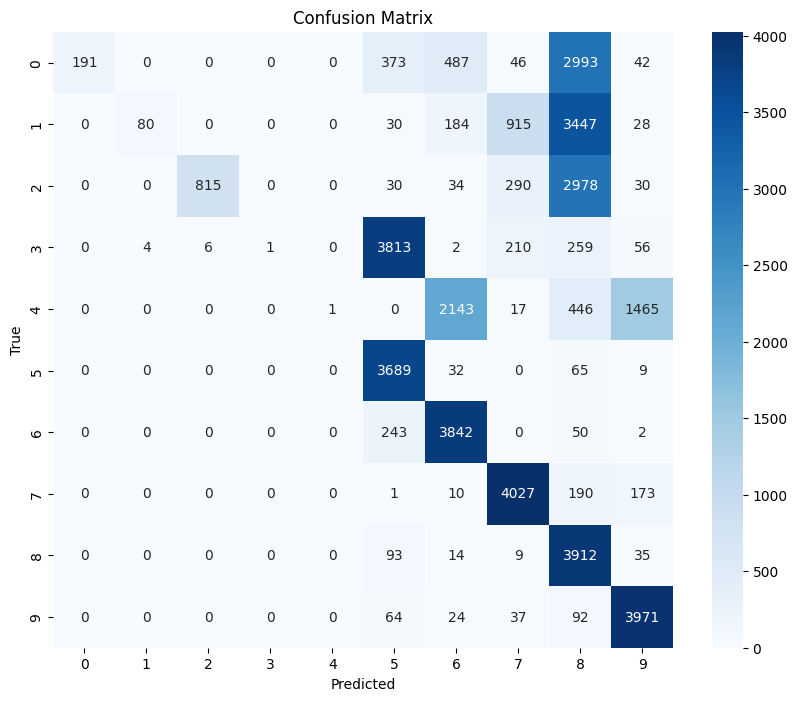

In [9]:
inference_on_model(feature_extractor,classification_head,data,10)

In [ ]:
def infer(f, c, loader, index):
    f.eval()
    c.eval()
    all_preds = []
    all_label = []
    img,label = loader[index]
    features = f(img.unsqueeze(0))
    logits = c(features)
    predictions = torch.argmax(logits, dim=1)
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.show()
    print(f"Predicted: {predictions.cpu().numpy()}")
    print(f"True:      {label.cpu().numpy()}")


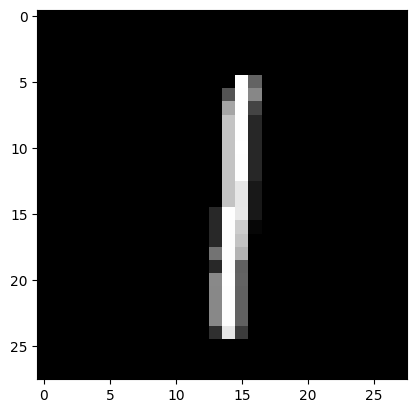

Predicted: [1]
True:      1


In [ ]:
infer(feature_extractor,classification_head,task1_data, 20000 )

In [ ]:
features = torch.randn(32, 128)
synthetic_images = synthesizer(features)

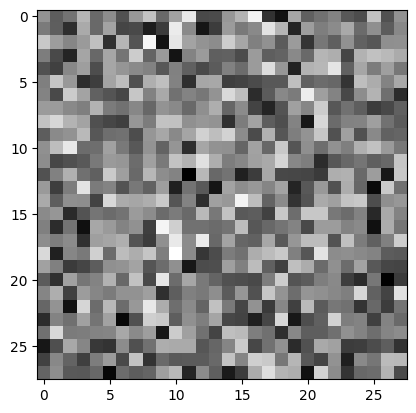

In [ ]:
plt.imshow(synthetic_images[0][0].detach(), cmap='gray')
plt.show()